This is a notebook for developing energy flux calculations.

Energy fluxes in Boundary Pass

In [1]:
import matplotlib.pylab as plt
import numpy as np
import scipy.io as sio
import netCDF4 as nc

from salishsea_tools import viz_tools
from nowcast import research_VENUS

import energy_flux as ef

import os

%matplotlib inline

In [2]:

SITES=research_VENUS.SITES['VENUS']
names=['Central','East']

In [3]:
path = '/ocean/nsoontie/MEOPAR/TidalEllipseData/'

data = sio.loadmat(os.path.join(path, 'BP_region_20141126_20150426_ssh'))
sshstruc = data['sshstruc']

data = sio.loadmat(os.path.join(path, 'BP_region_baroclinic_20141126_20150426_masked'))
bcstruc = data['datastruc']

data = sio.loadmat(os.path.join(path, 'BP_region_20141126_20150426_pbc_t'))
pbc_t_struc = data['pbc_t_struc']

data = sio.loadmat(os.path.join(path, 'BP_region_depav_20141126_20150426_masked'))
btstruc = data['datastruc']

In [4]:
grid=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
NEMO_lons = grid.variables['nav_lon'][:]
NEMO_lats = grid.variables['nav_lat'][:]
bathy=grid.variables['Bathymetry'][:]

mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
tmask = mesh.variables['tmask'][0,:,:,:]
e3t = mesh.variables['e3t'][0,:,:,:]


# Barotropic - M2

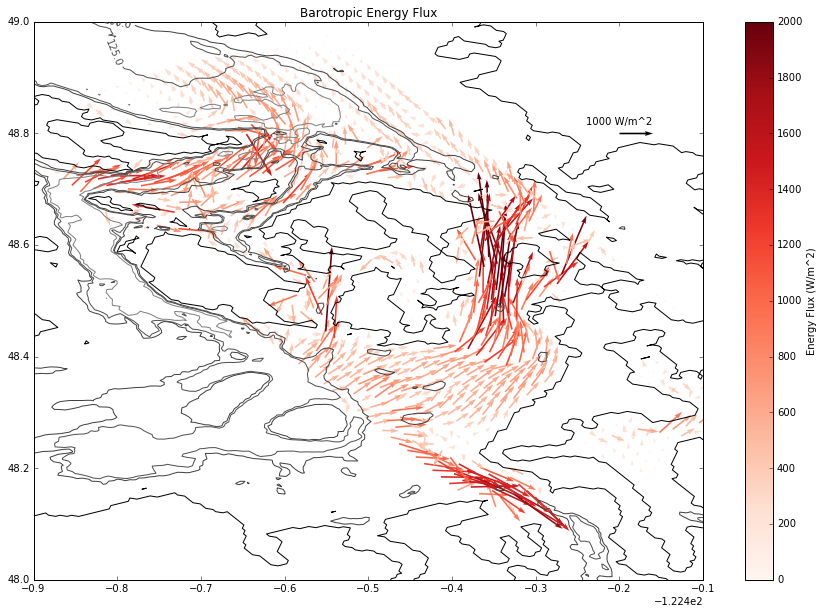

In [10]:
const='M2'
lons = sshstruc['lons'][0,0]
lats = sshstruc['lats'][0,0]

Fxbt,Fybt = ef.barotropic_flux(sshstruc, btstruc, const)
mag = np.sqrt(Fxbt**2+Fybt**2)
fig,ax=plt.subplots(1,1,figsize=(15,10))
st=3
q=ax.quiver(lons[::st,::st],lats[::st,::st],
            Fxbt[::st,::st],Fybt[::st,::st,],
            mag[::st,::st],cmap='Reds',clim=[0,2000],scale=2*10**4)
ax.set_xlim([-123.3,-122.5])
ax.set_ylim([48,49])
ax.set_title('Barotropic Energy Flux')
ax.quiverkey(q,-122.6,48.8,1000,'1000 W/m^2',color='k', coordinates='data')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Energy Flux (W/m^2)')
C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
manuel_locations=[(-123.2,49.15),(-123.2,49),(-123.2,48.95),(-123.35,49.15)]
plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
for name in names:
    ax.plot(SITES[name]['lon'],SITES[name]['lat'],'bo')

Depth-integrated will be more useful... More on this later.

# Baroclinic - M2
Near surface

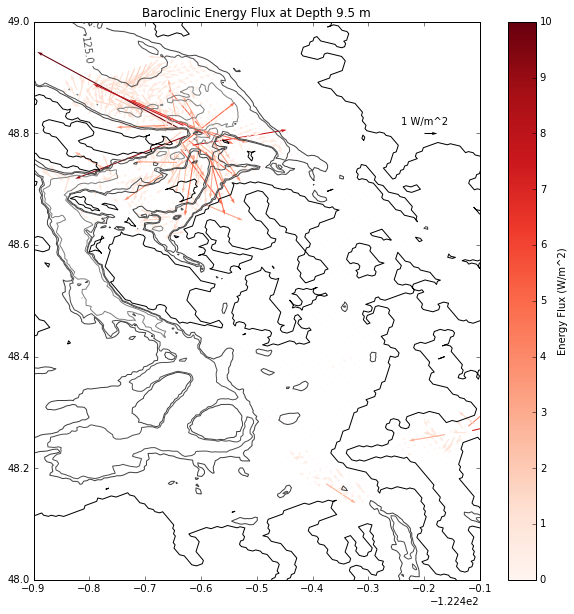

In [24]:
depths = pbc_t_struc['deptht'][0,0][:,0]

d=9
Fxbc,Fybc = ef.baroclinic_flux(pbc_t_struc, bcstruc,const)
fig,ax=plt.subplots(1,1,figsize=(10,10))
mag = np.sqrt(Fxbc[:,:,d]**2+Fybc[:,:,d]**2)
q = ax.quiver(lons[::st,::st],lats[::st,::st],
              Fxbc[::st,::st,d],Fybc[::st,::st,d],
              mag[::st,::st],cmap='Reds',clim=[0,10])

ax.set_title('Baroclinic Energy Flux at Depth {0:.3g} m'.format(depths[d]))
ax.quiverkey(q,-122.6,48.8,1,'1 W/m^2',color='k', coordinates='data')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Energy Flux (W/m^2)')

C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
ax.set_xlim([-123.3,-122.5])
ax.set_ylim([48,49])
plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
for name in names:
    ax.plot(SITES[name]['lon'],SITES[name]['lat'],'bo')

100 m

<a list of 4 text.Text objects>

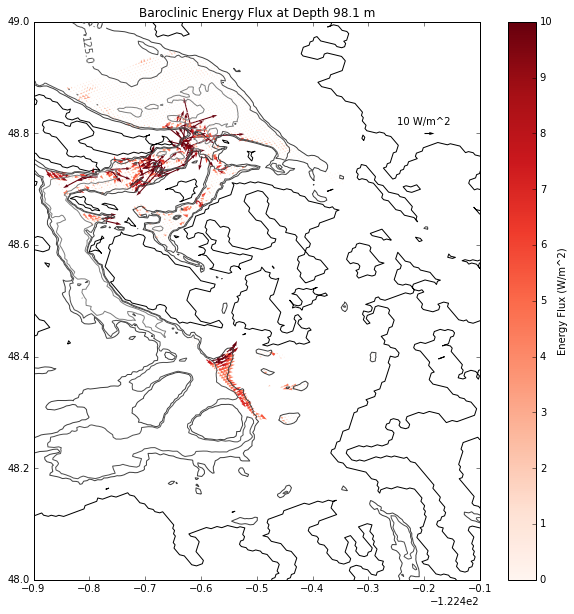

In [15]:
d=26
fig,ax=plt.subplots(1,1,figsize=(10,10))
mag = np.sqrt(Fxbc[:,:,d]**2+Fybc[:,:,d]**2)
q = ax.quiver(lons,lats,Fxbc[:,:,d],Fybc[:,:,d],mag,cmap='Reds',clim=[0,10])
ax.set_title('Baroclinic Energy Flux at Depth {0:.3g} m'.format(depths[d]))
ax.quiverkey(q,-122.6,48.8,10,'10 W/m^2',color='k', coordinates='data')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Energy Flux (W/m^2)')
C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
ax.set_xlim([-123.3,-122.5])
ax.set_ylim([48,49])
plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)

# Depth Integrated
Barotropic

In [16]:
column_depth = ef.water_depth(tmask,e3t)
jstart,istart = ef.find_starting_index(NEMO_lons,NEMO_lats,lons[0,0],lats[0,0])
jend = jstart + Fxbt.shape[-1]
iend = istart + Fxbt.shape[0]

Fxbt_depint = Fxbt*column_depth[jstart:jend, istart:iend].T
Fybt_depint = Fybt*column_depth[jstart:jend, istart:iend].T


Baroclinic

In [17]:
Fxbc_depint = ef.depth_integrate(Fxbc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))
Fybc_depint = ef.depth_integrate(Fybc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))

/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


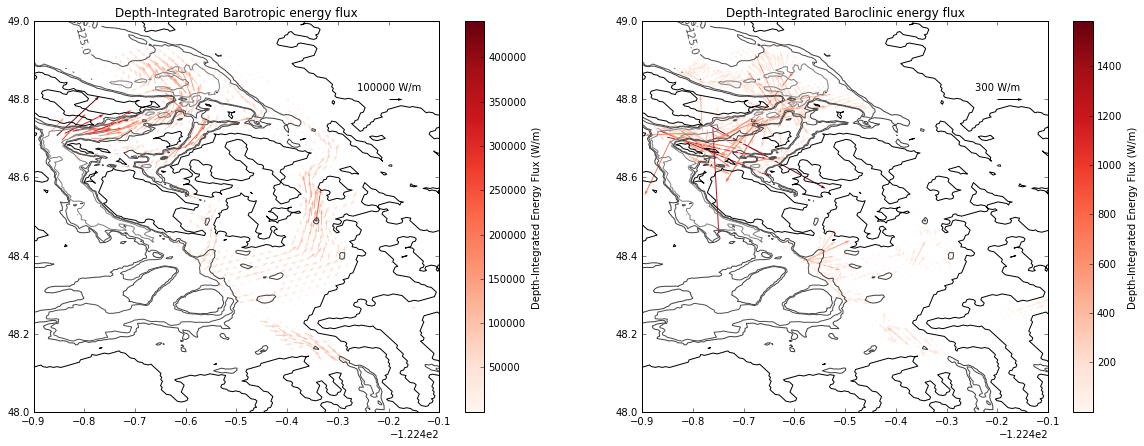

In [18]:
fig,axs=plt.subplots(1,2,figsize=(20,7))
st=3
#barotropic
ax=axs[0]
bt_mag = np.sqrt(Fxbt_depint**2 + Fybt_depint**2)
q=ax.quiver(lons[::st,::st],lats[::st,::st],
            Fxbt_depint[::st,::st],Fybt_depint[::st,::st],bt_mag[::st,::st],
            cmap='Reds')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Depth-Integrated Energy Flux (W/m)')
ax.set_title('Depth-Integrated Barotropic energy flux')
ax.quiverkey(q,-122.6,48.8,100000,'100000 W/m',color='k', coordinates='data')
#baroclinic
st=2
ax=axs[1]
bc_mag = np.sqrt(Fxbc_depint**2 + Fybc_depint**2)
q=ax.quiver(lons[::st,::st],lats[::st,::st],
            Fxbc_depint[::st,::st],Fybc_depint[::st,::st],bc_mag[::st,::st],
            cmap='Reds')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Depth-Integrated Energy Flux (W/m)')
ax.set_title('Depth-Integrated Baroclinic energy flux')
ax.quiverkey(q,-122.6,48.8,300,'300 W/m',color='k', coordinates='data')



for ax in axs:
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    ax.set_xlim([-123.3,-122.5])
    ax.set_ylim([48,49])
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for name in names:
        ax.plot(SITES[name]['lon'],SITES[name]['lat'],'bo')

How can I check if my calculations make sense?
* Foreman 1995 did similar barotropic calculations through Haro Strait. Perhaps I can repeat mine there....
* Can I do this without the harmonic analysis?

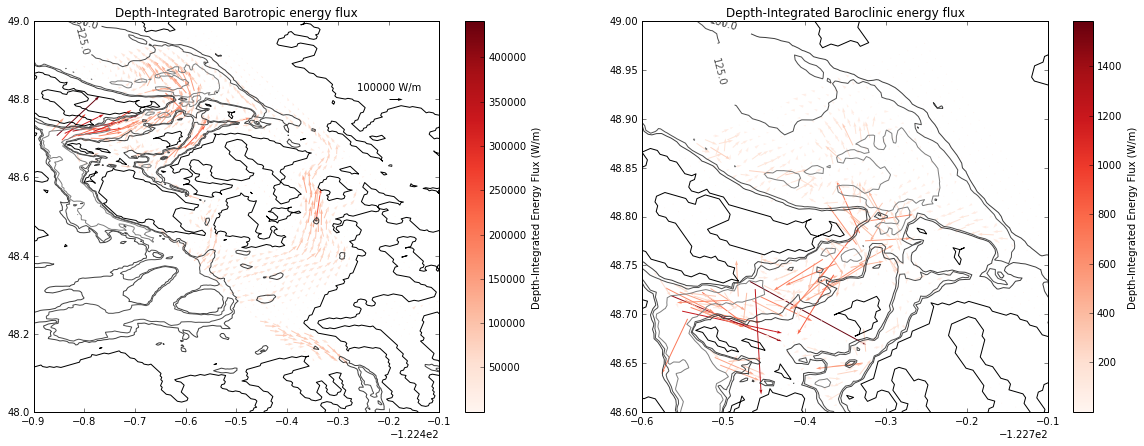

In [21]:
ax.set_xlim([-123.3,-122.8])
ax.set_ylim([48.6,49])
fig